# LIBRARY IMPORT

In [1]:
!pip install rouge

In [2]:
!pip install transformers[torch] datasets -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [3]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering,BlipImageProcessor, AutoProcessor,Blip2ForConditionalGeneration,Blip2Processor,BlipForConditionalGeneration
from transformers import BlipConfig
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pyarrow as pa
from datasets import Dataset
from  PIL import Image
import datasets
import cv2
from datasets import Image as Image2
import PIL
import accelerate

#LOAD DATASET

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_csv('dataset_v2.csv')
df['path'] = df['path'].apply(lambda x: x.replace("\\", "/"))
df['path'] = df['path'].apply(lambda x: x.replace( "./data/imgs",'/content/drive/MyDrive/Independent study/Images'))

In [6]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
model= BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

# Build dataset

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, questions, answers, image_paths, processor):
        self.questions = questions
        self.answers = answers
        self.image_paths = image_paths
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        # get image + text
        question = self.questions[idx]
        answer = self.answers[idx]
        image = Image.open(self.image_paths[idx]).convert("RGB")
        text = question

        encoding = self.processor(image, text, padding="max_length", max_length= 128,truncation=True, return_tensors="pt")
        labels = self.processor.tokenizer.encode(
            answer, max_length= 128, pad_to_max_length=True, return_tensors='pt'
        )
        encoding["labels"] = labels.squeeze(0)
        encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
        encoding["input_ids"] = encoding["input_ids"].squeeze(0)
        encoding["attention_mask"] = encoding["attention_mask"].squeeze(0)

        # remove batch dimension
        # for k,v in encoding.items():  encoding[k] = v.squeeze()
        return encoding

from torch.utils.data import DataLoader
from tqdm import tqdm

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    return batch




1-14 weeks

In [9]:
df_train=df[:8681]

15-16 weeks

In [10]:
df_test=df[8681:]

In [11]:
df_train=df_train.sample(frac=1).reset_index(drop=True)

In [12]:
questions = df_train['question'].to_list()
answers = df_train['answer'].to_list()
image_paths = df_train['path'].to_list()

train_dataset = VQADataset(questions = questions,
                          answers = answers,
                          image_paths = image_paths,
                          processor=processor)



In [13]:
questions = df_test['question'].to_list()
answers = df_test['answer'].to_list()
image_paths = df_test['path'].to_list()


test_dataset = VQADataset(questions = questions,
                          answers = answers,
                          image_paths = image_paths,
                          processor=processor)

In [14]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_dataset,
                              collate_fn=collate_fn,
                              batch_size=5,
                              shuffle=False)


In [15]:
batch = next(iter(train_dataloader))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")


In [17]:
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")


In [18]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] what does the learned model represent? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] it represents the output from the training process, used to make predictions. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

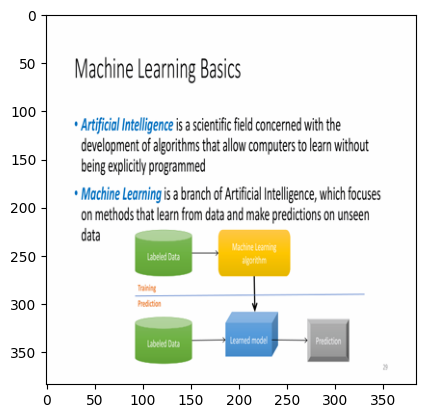

In [261]:
batch_idx = 0

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [38]:
batch_size = 100
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=False)

# MODEL TRAINING

In [20]:
device = torch.device("cuda")
model.to(device)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [21]:
model_root='/content/drive/MyDrive/Independent study/model_test_128_BEST.pt'

In [22]:
model.load_state_dict(torch.load(model_root))


<All keys matched successfully>

In [23]:
min_loss=100000

In [ ]:
model.train()
try :
 for epoch in range(60):
    print(f"Epoch: {epoch}")
    total_loss = []
    try :
     for batch in tqdm(train_dataloader):

        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimizeыа
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    except FileNotFoundError:
        print("The file was not found.")



    if np.mean(total_loss)<min_loss:
            min_loss=np.mean(total_loss)
            torch.save(model.state_dict(), '/content/drive/MyDrive/Independent study/model_test_200_2_1.pt')

    print("Loss:", np.mean(total_loss))
except FileNotFoundError:
        print("The file was not found.")

# OUTCOMES

In [24]:
def remove_repeated_phrases(sentence):
    words = sentence.split()
    # Check each possible phrase length
    for phrase_length in range(1, len(words) // 2 + 1):
        # Iterate over the sentence
        i = 0
        while i + phrase_length * 2 <= len(words):
            # Check if next phrase is a repeat
            if words[i:i + phrase_length] == words[i + phrase_length:i + 2 * phrase_length]:
                # Remove the repeated phrase
                del words[i + phrase_length:i + 2 * phrase_length]
            else:
                i += 1
    return ' '.join(words)

# Re-test the function


In [25]:
def delete_after_comma_if_no_period(sentence):
    # Check if the sentence ends with a period
    if not sentence.endswith('.'):
        # Split the sentence at the comma
        parts = sentence.split(',', 1)
        # Return the part before the comma if there is only one word after the comma
        if len(parts) > 1 and len(parts[1].split()) <= 1:
            return parts[0]
        else:
            return sentence
    else:
        # Return the sentence as it is if it ends with a period
        return sentence


In [26]:
def  show_predition(batch_idx, model, dataset, explain_slide=False):
  train_dataset=dataset
  sample = train_dataset[batch_idx]



  if explain_slide==True:
    sample2 = train_dataset[490]


    print("Question: Can you explain this slide?")
    sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}
    sample2 = {k: v.unsqueeze(0).to(device) for k,v in sample2.items()}
    input_ids=sample2['input_ids']


  else:
      print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
      sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}
      input_ids=sample['input_ids']





  # forward pass
  outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=input_ids)
  print("Predicted Answer: ",delete_after_comma_if_no_period(remove_repeated_phrases(text_processor.decode(outputs[0],skip_special_tokens=True))))
  print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
  #########################################################################
  unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
  unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
  unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
  plt.imshow(Image.fromarray(unnormalized_image))



## Train

Question:  what does the learned model represent?
Predicted Answer:  it emphasizes that the algorithm learns and adapts the algorithm, making it more versatile
Actual Answer:  it represents the output from the training process, used to make predictions.


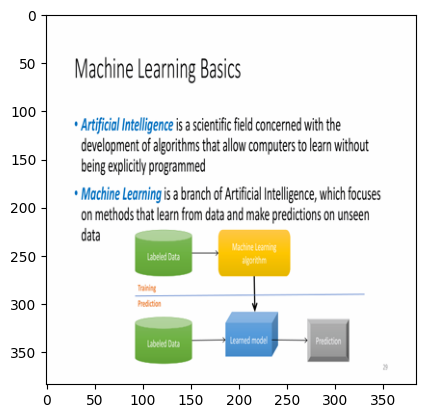

In [188]:
 show_predition(0,model,train_dataset)

Question:  can you explain this slide?
Predicted Answer:  it emphasizes that iteratively combines probabilities for different classifiers
Actual Answer:  slide explains linear svm : margin calculated by scalar projection of pos. and neg. examples on unit normal vector. margin width = 2 / | | w | |.


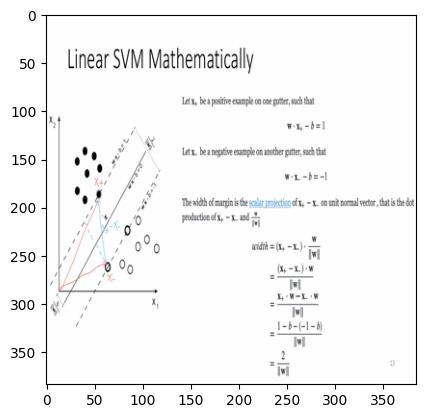

In [189]:
 show_predition(200,model,train_dataset)

Question:  what do the equations at the bottom represent?
Predicted Answer:  they provide that iteratively adjusts the parameters for better results, unlike other challenges in optimization
Actual Answer:  they detail how to compute the updated parameters in the maximization step.


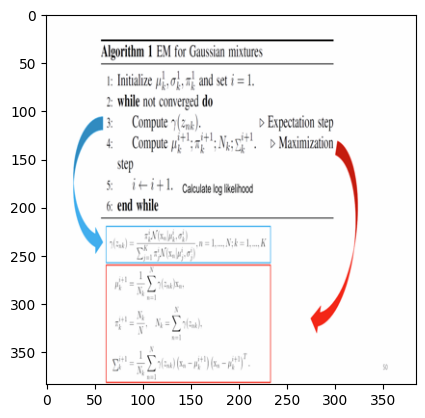

In [ ]:
 show_predition(300,model,train_dataset)

Question:  what is the primary difference between hard and soft margin?
Predicted Answer:  the iterative process ensures probabilities between 0 and 1, with a single leaf, and
Actual Answer:  hard margin requires perfect separation of classes. soft margin allows some misclassifications using slack variables.


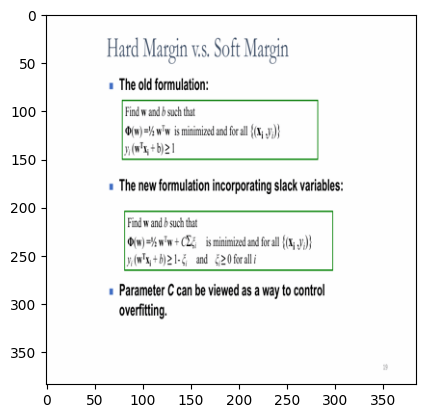

In [190]:
 show_predition(1150,model,train_dataset)

Question:  what is the range of outputs for logistic regression?
Predicted Answer:  it ensures that it emphasizes that it enhances the hypothesis for better results, especially in large data
Actual Answer:  for logistic regression, outputs range from 0 to 1.


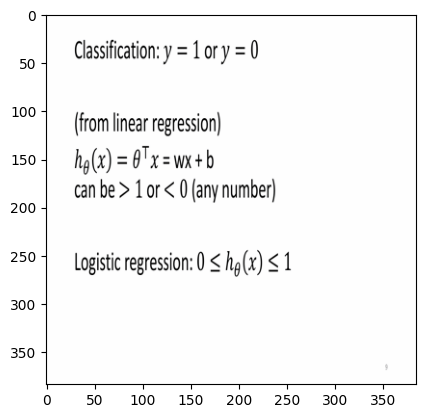

In [191]:
 show_predition(1234,model,train_dataset)

Question:  how does the svm decide the boundary?
Predicted Answer:  it ensures that svm finds the best possible probability of correctly classifying its large margin
Actual Answer:  svm decides the boundary by finding a hyperplane that maximizes the margin between the two classes while correctly classifying all training data.


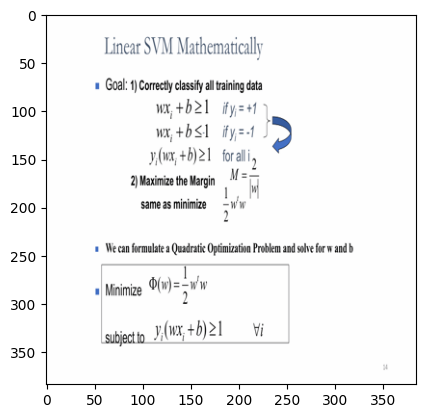

In [192]:
show_predition(2345,model,train_dataset)

Question:  what is the principal eigenvalue?
Predicted Answer:  it ensures that the algorithm identified observed features and often makes it more interpretable.
Actual Answer:  the principal eigenvalue is the first and largest eigenvalue, associated with an orthonormal eigenvector.


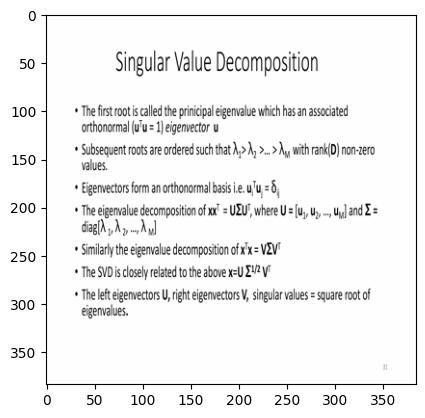

In [193]:
show_predition(768,model,train_dataset)

Question:  what is the goal of the method of least squares?
Predicted Answer:  it aims to minimize the sum of squared differences between observed and predicted values.
Actual Answer:  the goal is to minimize the sum of squared differences for best fit.


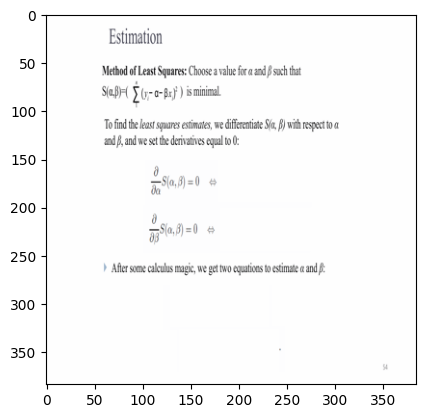

In [194]:
show_predition(46,model,train_dataset)

Question:  highlight the main points of this slide.
Predicted Answer:  it ensures that it emphasizes that larger it in each iteration, and doesn't need training.
Actual Answer:  main points : svm's flexibility, efficiency with big data, vast feature space management, overfitting control, unique math property, and feature selection.


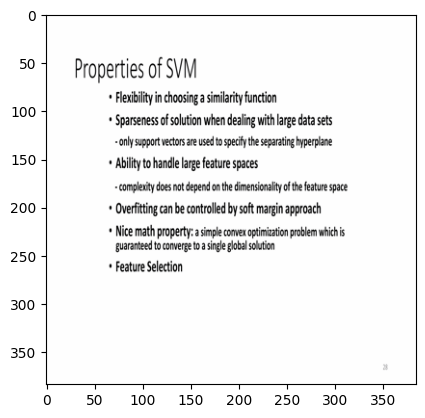

In [110]:
show_predition(4567,model,train_dataset)

Question:  how is bayes'theorem used in the context of this slide?
Predicted Answer:  it ensures that it measures the joint likelihood of observing the given conditions, as indicated by the joint
Actual Answer:  bayes'theorem is used to relate the probability of a model given data to the probability of data given a model.


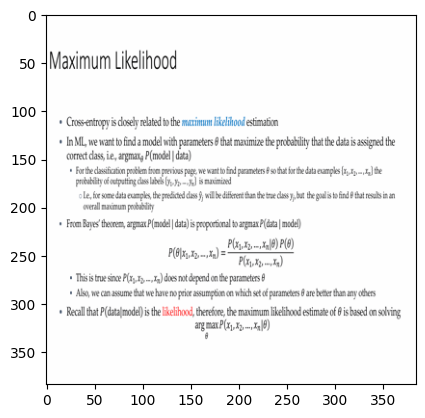

In [112]:
show_predition(4532,model,train_dataset, model)

Question:  is em an iterative process?
Predicted Answer:  iteratively combines probabilities with respect to each gaussian contributes to the expectation.
Actual Answer:  yes, em is an iterative optimization method.


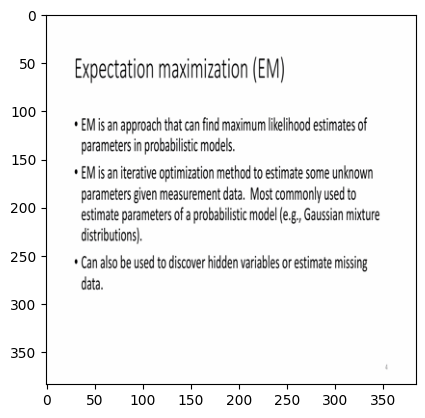

In [195]:
show_predition(234,model,train_dataset)

## Test

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Question:  why is it important that predictors have uncorrelated errors?
Predicted Answer:  it ensures that the algorithm makes fewer assumptions about the best fit of the data
Actual Answer:  it prevents consistent biases across models, making the ensemble more resistant to specific errors.


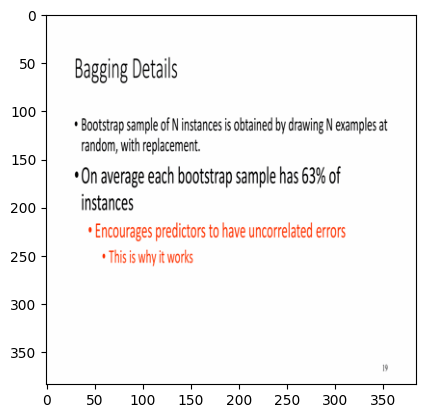

In [271]:
 show_predition(200,model,test_dataset)

Question:  which job position is'capital one'recruiting for?
Predicted Answer:  it ensures that it emphasizes the proportion of support vectors distort the decision boundary
Actual Answer:  capital one is recruiting for the'machine learning engineer'position.


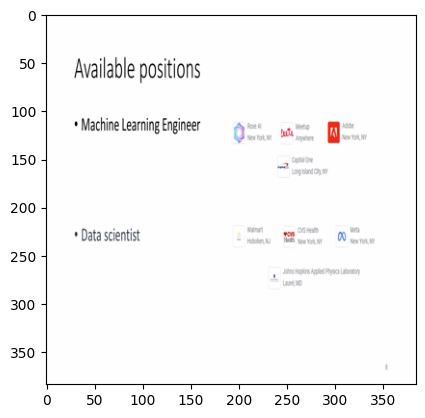

In [272]:
 show_predition(700,model,test_dataset)

Question:  can you explain this slide?
Predicted Answer:  it emphasizes that it enhances the function f ( x ) with respect to x
Actual Answer:  the slide showcases different loss functions, their equations, and their behavior in terms of correct and incorrect classification.


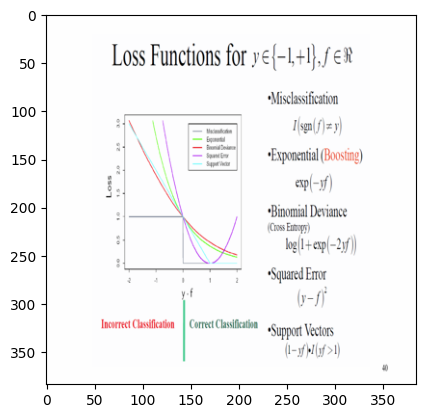

In [276]:
 show_predition(410,model,test_dataset)

Question:  is boosting about ignoring easy instances?
Predicted Answer:  it ensures that the iteratively adjusts the parameters, leading to a more
Actual Answer:  no, boosting doesn't ignore easy instances, but it gives more attention to difficult ones.


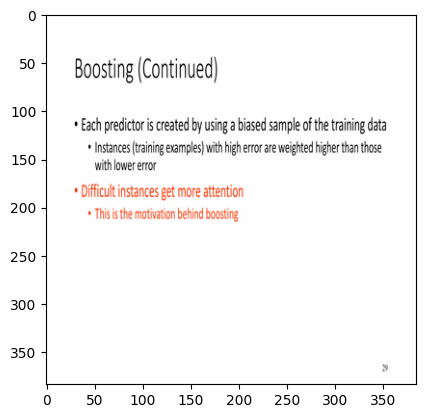

In [277]:
 show_predition(300,model,test_dataset)

Question:  what do children receive a lot of, according to the slide?
Predicted Answer:  children grasp enhances its ability, often in tasks like children, making it more versatile in tasks
Actual Answer:  children receive an enormous amount of data as input.


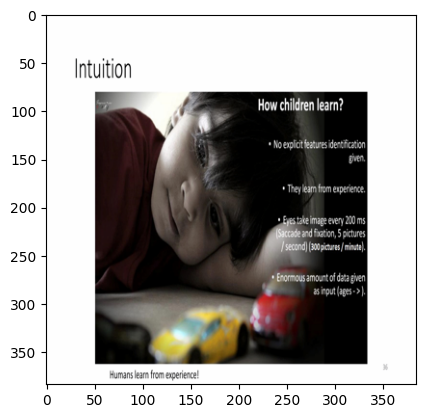

In [136]:
 show_predition(50,model,train_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Question:  can you explain this slide?
Predicted Answer:  it emphasizes that larger it in diverse scenarios, but doesn't fit between predicted
Actual Answer:  the slide presents the ensemble learning process. it starts with creating multiple datasets, then building multiple classifiers, and finally combining the classifiers for a unified result.


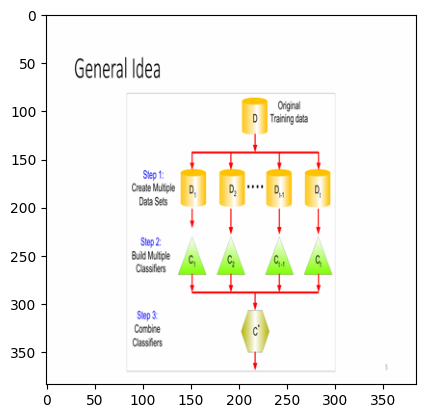

In [280]:
 show_predition(50,model,test_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Question:  can you explain this slide?
Predicted Answer:  it ensures that it emphasizes that it enhances the hypothesis over all training examples, leading to a
Actual Answer:  the slide gives three solutions for someone new in town to find a good restaurant : consulting a food critic, reading a random google review, and averaging multiple google reviews.


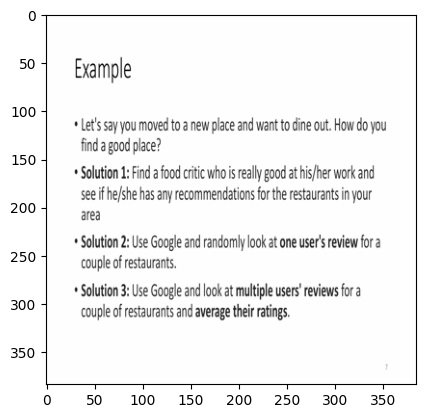

In [279]:
 show_predition(75,model,test_dataset)

# Can you explain this slide?

### Train

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Question: Can you explain this slide?


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  iteratively combines diverse attributes, leading to a more accurate and reliable predictions.
Actual Answer:  it represents the output from the training process, used to make predictions.


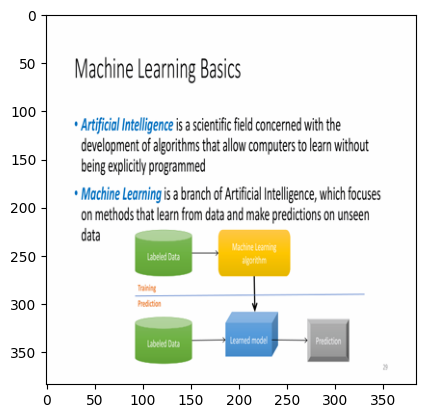

In [185]:
show_predition(0, model, train_dataset, explain_slide=True)


Question: Can you explain this slide?
Predicted Answer:  it ensures that iteratively combines probabilities for better results, unlike other methods like k
Actual Answer:  attributes that split data well lead to better and more efficient classifications.


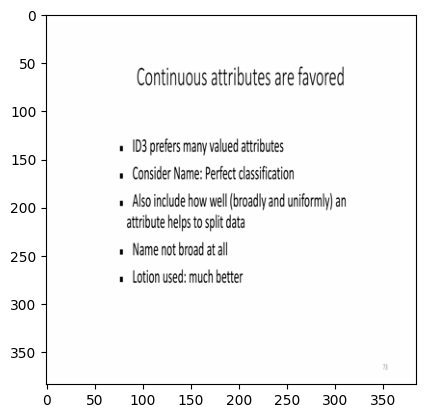

In [201]:
 show_predition(215,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  it ensures that iteratively adjusts the parameters for better results, unlike other algorithms where they
Actual Answer:  they detail how to compute the updated parameters in the maximization step.


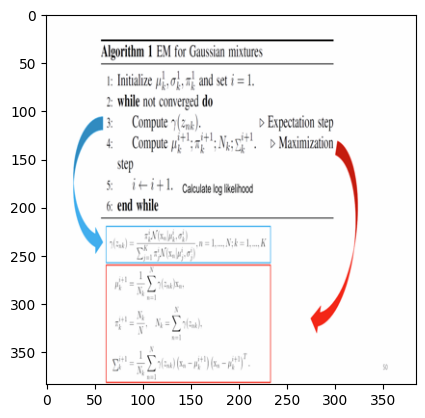

In [202]:
 show_predition(300,model,train_dataset,explain_slide=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Question: Can you explain this slide?
Predicted Answer:  it ensures that the algorithm performs well on the validation set, leading to more accurate
Actual Answer:  gelu stands for gaussian error linear unit, used in the multi - layer perceptrons layer.


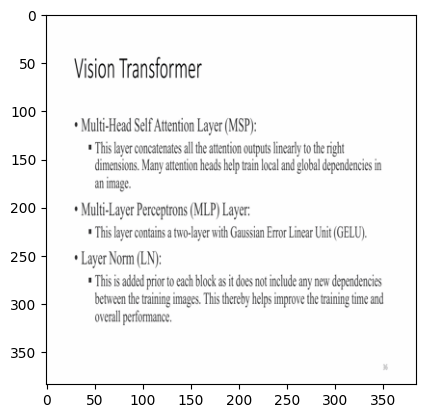

In [216]:
 show_predition(7740,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  it ensures that iteratively combines probabilities for better results, unlike other methods like k
Actual Answer:  the classifying function is represented as f ( x ) = σαiyixi ^ tx + b.


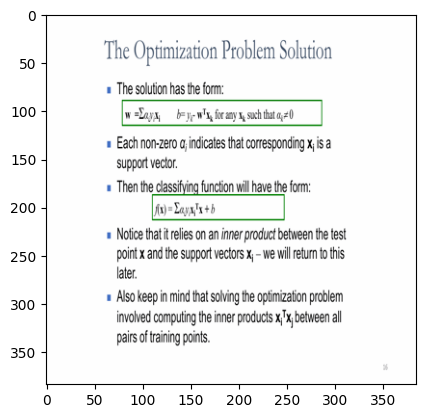

In [205]:
 show_predition(7000,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  it ensures that the algorithm makes fewer assumptions about the best fit between the data point
Actual Answer:  no, all attributes may not even appear in the tree.


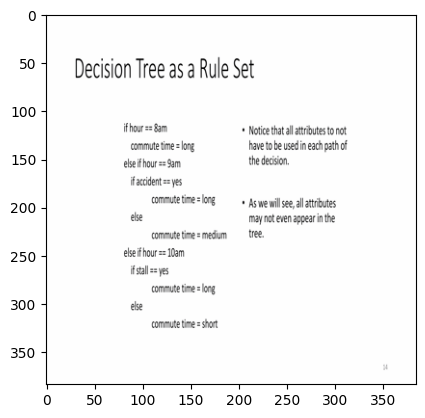

In [209]:
 show_predition(800,model,train_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  it ensures that the algorithm performs well on the validation set, leading to more accurate
Actual Answer:  the goal is to minimize the sum of squared differences for best fit.


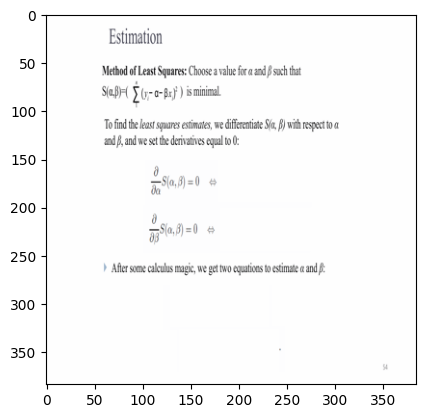

In [212]:
 show_predition(46,model,train_dataset,explain_slide=True)

## Test

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Question: Can you explain this slide?


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Answer:  it emphasizes that it enhances the hypothesis, especially with large number of classes,
Actual Answer:  it prevents consistent biases across models, making the ensemble more resistant to specific errors.


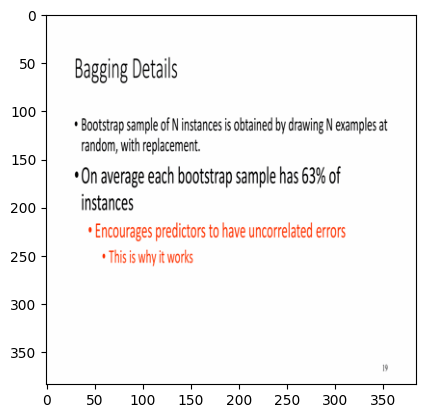

In [281]:
 show_predition(200,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  it ensures that it emphasizes that it enhances the hypothesis, making it more interpretable and interpret
Actual Answer:  capital one is recruiting for the'machine learning engineer'position.


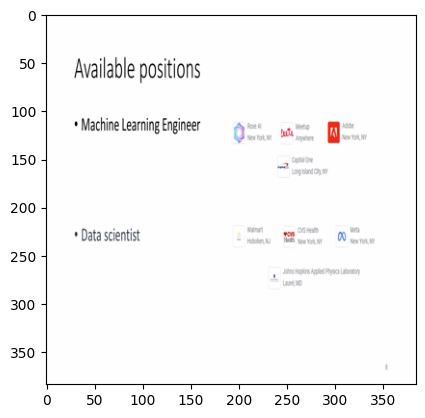

In [283]:
 show_predition(700,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  it emphasizes that it enhances the function f ( x ) with respect to x
Actual Answer:  the slide showcases different loss functions, their equations, and their behavior in terms of correct and incorrect classification.


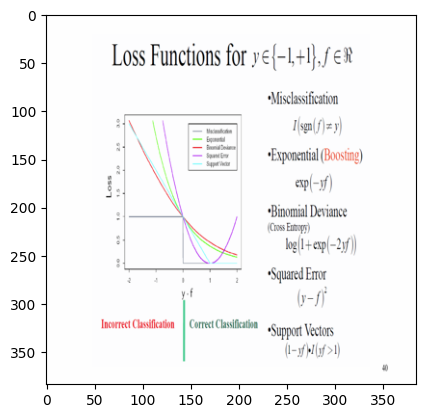

In [284]:
 show_predition(410,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  it emphasizes that it enhances the log likelihood of
Actual Answer:  no, boosting doesn't ignore easy instances, but it gives more attention to difficult ones.


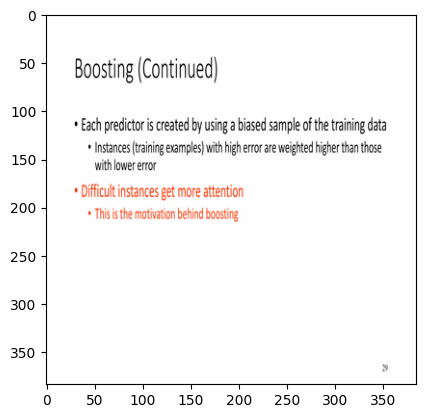

In [285]:
 show_predition(300,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  it emphasizes that larger it in diverse scenarios, but doesn't fit between predicted
Actual Answer:  the slide presents the ensemble learning process. it starts with creating multiple datasets, then building multiple classifiers, and finally combining the classifiers for a unified result.


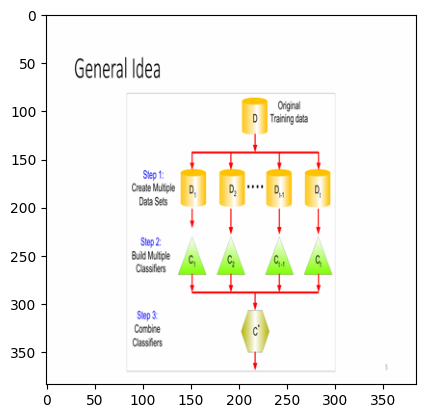

In [286]:
 show_predition(50,model,test_dataset,explain_slide=True)

Question: Can you explain this slide?
Predicted Answer:  it ensures that it emphasizes that it enhances the hypothesis over all training examples, leading to a
Actual Answer:  the slide gives three solutions for someone new in town to find a good restaurant : consulting a food critic, reading a random google review, and averaging multiple google reviews.


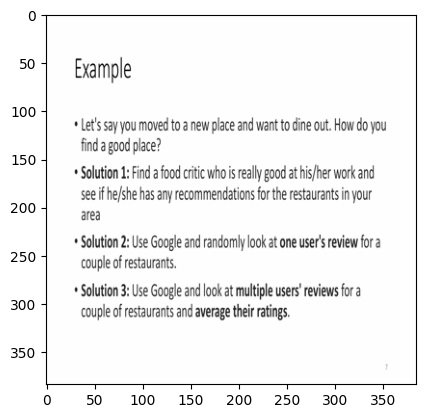

In [287]:
 show_predition(75,model,test_dataset,explain_slide=True)

# METRICS

## COSINE SIMILARITY

In [51]:
from torch.nn.functional import cosine_similarity
from tqdm import tqdm
import torch


In [ ]:

model.eval()

Test

In [65]:
cosine_similarities = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Ensure generated_indices and labels have compatible dimensions
        if generated_indices.size(1) != labels.size(1):
            if generated_indices.size(1) > labels.size(1):
                generated_indices = generated_indices[:, :labels.size(1)]
            else:
                padding_size = labels.size(1) - generated_indices.size(1)
                padding = torch.zeros((generated_indices.size(0), padding_size), device=labels.device)
                generated_indices = torch.cat([generated_indices, padding], dim=1)

        # Compute cosine similarity for each pair in the batch
        for idx in range(generated_indices.size(0)):
            cos_sim = cosine_similarity(generated_indices[idx].unsqueeze(0), labels[idx].unsqueeze(0))
            cosine_similarities.append(cos_sim.item())


100%|██████████| 8/8 [00:31<00:00,  3.92s/it]


In [66]:
avg_cosine_similarity = np.mean(cosine_similarities)
print("Average Cosine Similarity on Test Data:", avg_cosine_similarity)

Average Cosine Similarity on Test Data: 0.37385734679544863


Train

In [ ]:
cosine_similarities = []
with torch.no_grad():
    for i,batch in enumerate(train_dataloader):
        print(i)
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Ensure generated_indices and labels have compatible dimensions
        if generated_indices.size(1) != labels.size(1):
            if generated_indices.size(1) > labels.size(1):
                generated_indices = generated_indices[:, :labels.size(1)]
            else:
                padding_size = labels.size(1) - generated_indices.size(1)
                padding = torch.zeros((generated_indices.size(0), padding_size), device=labels.device)
                generated_indices = torch.cat([generated_indices, padding], dim=1)

        # Compute cosine similarity for each pair in the batch
        for idx in range(generated_indices.size(0)):
            cos_sim = cosine_similarity(generated_indices[idx].unsqueeze(0), labels[idx].unsqueeze(0))
            cosine_similarities.append(cos_sim.item())


In [63]:
avg_cosine_similarity = np.mean(cosine_similarities)
print("Average Cosine Similarity on Train Data:", avg_cosine_similarity)

Average Cosine Similarity on Tran Data: 0.3726054448657452


## BLEU

Test

In [28]:
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm
import torch

In [29]:
model.eval()

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

Test

In [325]:
bleu_scores = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Convert the generated indices and labels to words
        for idx in range(generated_indices.size(0)):
            ref_sentence = text_processor.decode(labels[idx], skip_special_tokens=True).split()
            gen_sentence = remove_repeated_phrases(text_processor.decode(generated_indices[idx], skip_special_tokens=True)).split()

            # Compute BLEU score for each sentence
            score = sentence_bleu([ref_sentence], gen_sentence, weights=(0.25, 0.25, 0.25, 0.25))
            bleu_scores.append(score)

avg_bleu_score = np.mean(bleu_scores)
print("Average BLEU Score on Test Data:", avg_bleu_score)


100%|██████████| 8/8 [00:33<00:00,  4.16s/it]

Average BLEU Score on Test Data: 0.153598603911637


Train

In [ ]:
bleu_scores = []
with torch.no_grad():
    for i,batch in enumerate(train_dataloader):
        print(i)
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Convert the generated indices and labels to words
        for idx in range(generated_indices.size(0)):
            ref_sentence = text_processor.decode(labels[idx], skip_special_tokens=True).split()
            gen_sentence = remove_repeated_phrases(text_processor.decode(generated_indices[idx], skip_special_tokens=True)).split()

            # Compute BLEU score for each sentence
            score = sentence_bleu([ref_sentence], gen_sentence, weights=(0.25, 0.25, 0.25, 0.25))
            bleu_scores.append(score)

avg_bleu_score = np.mean(bleu_scores)

In [43]:
print("Average BLEU Score on Train Data:", avg_bleu_score)

Average BLEU Score on Train Data: 0.1638060539650635


## Rouge

In [46]:
from rouge import Rouge
from tqdm import tqdm
import torch

Test

In [48]:


model.eval()

# Initialize Rouge
rouge = Rouge()

rouge_scores = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Convert the generated indices and labels to text
        for idx in range(generated_indices.size(0)):
            # Assuming tokenizer.decode() method to convert IDs to text
            reference_text = processor.decode(labels[idx], skip_special_tokens=True)
            generated_text = processor.decode(generated_indices[idx], skip_special_tokens=True)

            # Compute ROUGE score for each sentence
            scores = rouge.get_scores(generated_text, reference_text)
            rouge_scores.append(scores)  # Scores is a dict with 'rouge-1', 'rouge-2', 'rouge-l'

# Calculate average of ROUGE scores
average_rouge_scores = np.mean([score[0]['rouge-1']['f'] for score in rouge_scores])


print("Average ROUGE Scores on Test Data:", average_rouge_scores)


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 8/8 [01:20<00:00, 10.03s/it]

Average ROUGE Scores on Test Data: 0.3582207895015318


In [ ]:
# Initialize Rouge
rouge = Rouge()
rouge_scores = []

with torch.no_grad():
    for i,batch in enumerate(train_dataloader):
        print(i)
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        generated_indices = model.generate(
            input_ids=inputs['input_ids'],
            pixel_values=inputs['pixel_values'],
            attention_mask=inputs['attention_mask']
        )

        # Convert the generated indices and labels to text
        for idx in range(generated_indices.size(0)):
            # Assuming tokenizer.decode() method to convert IDs to text
            reference_text = processor.decode(labels[idx], skip_special_tokens=True)
            generated_text = processor.decode(generated_indices[idx], skip_special_tokens=True)

            # Compute ROUGE score for each sentence
            scores = rouge.get_scores(generated_text, reference_text)
            rouge_scores.append(scores)  # Scores is a dict with 'rouge-1', 'rouge-2', 'rouge-l'



In [50]:
# Calculate average of ROUGE scores
average_rouge_scores = np.mean([score[0]['rouge-1']['f'] for score in rouge_scores])

print("Average ROUGE Scores on Train Data:", average_rouge_scores)


Average ROUGE Scores on Train Data: 0.36335832156267556
